In [43]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

path_to_data = '/content/drive/MyDrive/dseb-dl/data'

train_X = np.load(os.path.join(path_to_data, 'train_X.npy'))
train_Y = np.load(os.path.join(path_to_data, 'train_Y.npy'))
train_bboxes = np.load(os.path.join(path_to_data, 'train_bboxes.npy'))
train_seg = np.load(os.path.join(path_to_data, 'train_seg.npy'))

valid_X = np.load(os.path.join(path_to_data, 'valid_X.npy'))
valid_Y = np.load(os.path.join(path_to_data, 'valid_Y.npy'))
valid_bboxes = np.load(os.path.join(path_to_data, 'valid_bboxes.npy'))
valid_seg = np.load(os.path.join(path_to_data, 'valid_seg.npy'))

class ExtendedMNISTDataset(Dataset):
    def __init__(self, images, labels, bboxes, segments):
        self.images = images
        self.labels = labels
        self.bboxes = bboxes
        self.segments = segments

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(64, 64, 3)
        label = self.labels[idx]
        bbox = self.bboxes[idx]
        segment = self.segments[idx].reshape(64, 64)

        image = torch.from_numpy(image).float() / 255.0
        image = image.permute(2, 0, 1)
        bbox = torch.tensor(bbox, dtype=torch.float32)
        segment = torch.tensor(segment, dtype=torch.long)

        return image, label, bbox, segment


train_dataset = ExtendedMNISTDataset(train_X, train_Y, train_bboxes, train_seg)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = ExtendedMNISTDataset(valid_X, valid_Y, valid_bboxes, valid_seg)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


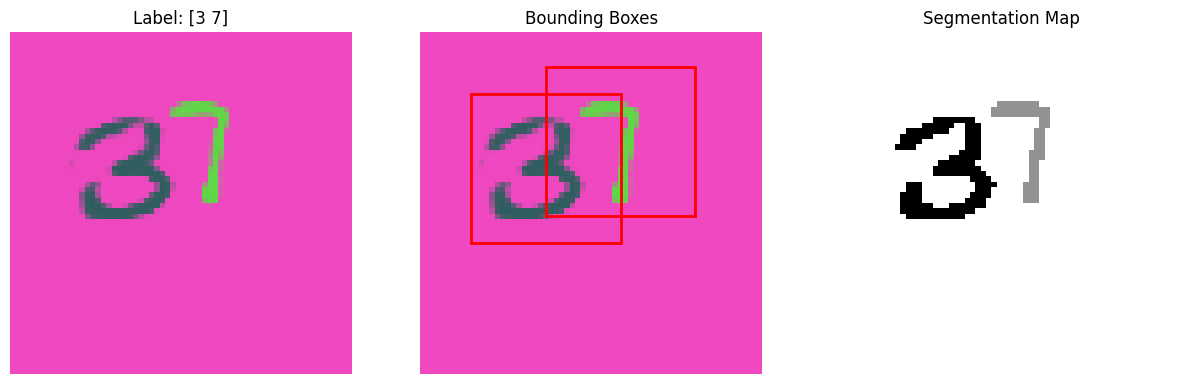

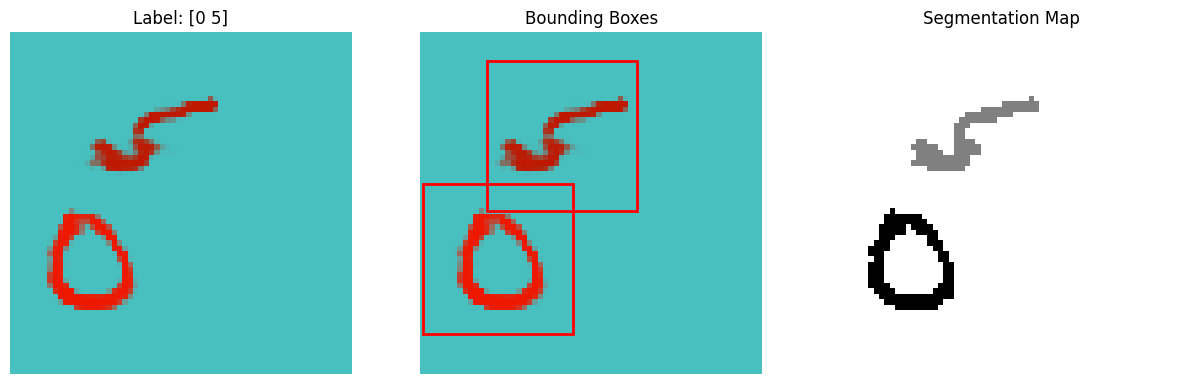

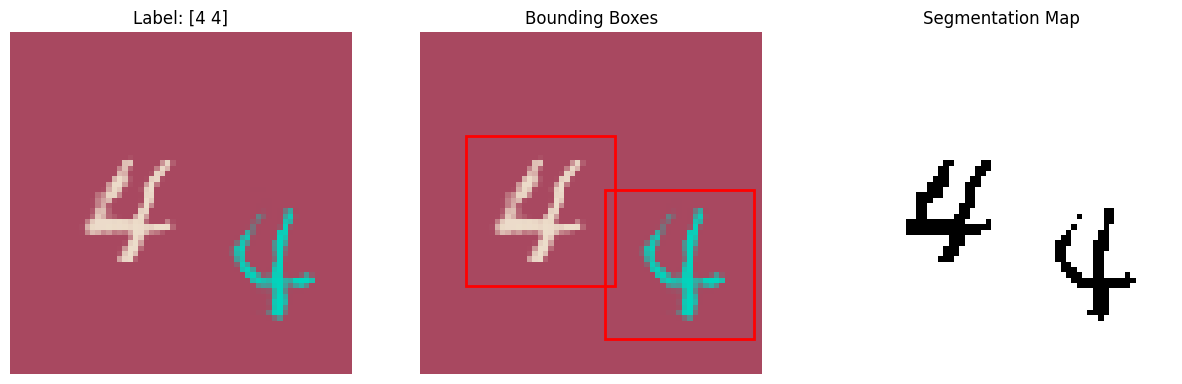

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_example(image, label, bboxes, segment):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    image_display = image.permute(1, 2, 0)

    axs[0].imshow(image_display)
    axs[0].set_title(f"Label: {label}")
    axs[0].axis('off')

    axs[1].imshow(image_display)
    for bbox in bboxes:
        y_min, x_min, y_max, x_max = bbox
        axs[1].add_patch(patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none'))
    axs[1].set_title('Bounding Boxes')
    axs[1].axis('off')

    axs[2].imshow(segment, cmap='gray')
    axs[2].set_title('Segmentation Map')
    axs[2].axis('off')

    plt.show()


for i in range(3):
    image, label, bboxes, segment = train_dataset[i]
    show_example(image, label, bboxes, segment)


In [41]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import torchvision
from torchvision.models.detection import ssdlite320_mobilenet_v3_large

def get_ssd_mobilenet_model(num_classes):
    model = ssdlite320_mobilenet_v3_large(pretrained=True)
    model.head.classification_head.num_classes = num_classes
    return model


def get_segmentation_model(num_classes):
    model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
    return model


In [29]:
import torch


def train_one_epoch_detection(model, data_loader, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels, bboxes, segments in data_loader:
        images = list(image.to(device) for image in images)

        targets = []
        for label, bbox in zip(labels, bboxes):
            target = {}
            target['boxes'] = bbox.to(device)
            target['labels'] = label.to(device)
            targets.append(target)

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    return running_loss / len(data_loader)


@torch.no_grad()
def validate_detection(model, data_loader, device):
    model.eval()
    validation_loss = 0.0

    for images, labels, bboxes, segments in data_loader:
        images = list(image.to(device) for image in images)

        targets = []
        for label, bbox in zip(labels, bboxes):
            target = {}
            target['boxes'] = bbox.to(device)
            target['labels'] = label.to(device)
            targets.append(target)

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        validation_loss += losses.item()

    return validation_loss / len(data_loader)

In [ ]:
num_classes = 11
num_epochs = 10
device = "cuda"
torch.cuda.empty_cache()

detection_model = get_ssd_mobilenet_model(num_classes).to(device)
det_optimizer = torch.optim.Adam(detection_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_loss = train_one_epoch_detection(detection_model, train_loader, det_optimizer, device)
    valid_loss = validate_detection(detection_model, valid_loader, device)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
